## Gender Classification with Neural Networks using First Names

In [69]:
# import all the required libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [70]:
# Read the dataset
df = pd.read_csv("../assets/data/gender.csv")

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    1294 non-null   object
 1   Target  1294 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.3+ KB


In [72]:
df.head()

,Name,Target
0,Yash,1
1,Prit,1
2,Meet,1
3,Drashti,0
4,Saloni,0


In [73]:
# Converting all names to lowercase
df['Name'] = df['Name'].str.lower()
df.head()

,Name,Target
0,yash,1
1,prit,1
2,meet,1
3,drashti,0
4,saloni,0


In [74]:
# Convert each name to feature vector
X = []
y = []

# Considering the last character and bigrams in name
num_feats = 702    # 26 letters + 26*26 bigrams = 702 features

for i in range(len(df)):
  name = df.iloc[i]['Name']
  target = df.iloc[i]['Target']

  vec = np.zeros(num_feats)

  # Consider last letter of name
  key = name[-1]
  if not (ord(key) < 97 or ord(key) > 122):
    vec[ord(key)-97] = 1

  # Consider all bigrams
  for i in range(len(name)-1):
    bigram = name[i:i+2]
    # Skipping whitespace and extra characters if any
    if (ord(bigram[0]) < 97 or ord(bigram[0]) > 122 or ord(bigram[1]) < 97 or ord(bigram[1]) > 122):
      continue
    vec[26 + (ord(bigram[0]) - 97)*26 + (ord(bigram[1]) - 97)] = 1

  vec = vec.reshape(-1, 1)
  X.append(vec)

  if target == 0:
    # 0 represents girl
    y.append(0)
  else:
    # 1 represents boy
    y.append(1)

# Printing sample feature vector and label
print(X[0].shape)
print(y[0])

(702, 1)
1


In [75]:
# Split data into train, val and test sets
test_size = 0.1
val_size = 0.1

data = list(zip(X, y))

split_index1 = int(len(data) * (1 - test_size - val_size))
split_index2 = int(len(data) * (1 - test_size))
train_data = data[:split_index1]
val_data = data[split_index1:split_index2]
test_data = data[split_index2:]

X_train, y_train = zip(*train_data)
X_test, y_test = zip(*test_data)
X_val, y_val = zip(*val_data)

X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)
X_val, y_val = np.array(X_val), np.array(y_val)

# y_train = y_train.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)
# y_val = y_val.reshape(-1, 1)

print(f'Number of training examples: {len(X_train)}')
print(f'Number of validation examples: {len(X_val)}')
print(f'Number of test examples: {len(X_test)}')

Number of training examples: 1035
Number of validation examples: 129
Number of test examples: 130


In [76]:
# Computes the sigmoid function
def sigmoid(z):
    return (1.0 / (1 + np.exp(-z)))

# Computes derivative of activation with respect to z
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [77]:
# Computes the binary cross-entropy loss
epsilon = 1e-10

# This loss is for a point only
def loss(y, a):
    a = np.clip(a, epsilon, 1 - epsilon)
    return -((y*np.log(a)) + ((1 - y)*np.log(1 - a)))

# Computes derivative of loss with respect to activations
def loss_prime(y, a):
    a = np.clip(a, epsilon, 1 - epsilon)
    return ((a-y) / (a*(1-a)))

In [78]:
# Defining architecture with name vector as input and single output
architecture = [num_feats, 100, 1]

In [79]:
# Initializing randomly
weights = [np.random.randn(x,y) for x,y in zip(architecture[1:], architecture[:-1])]
biases = [np.random.randn(y,1) for y in architecture[1:]]

for i in range(len(weights)):
    print(f'weight matrix {i} shape: {weights[i].shape}')

for i in range(len(biases)):
    print(f'bias matrix {i} shape: {biases[i].shape}')

weight matrix 0 shape: (100, 702)
weight matrix 1 shape: (1, 100)
bias matrix 0 shape: (100, 1)
bias matrix 1 shape: (1, 1)


In [80]:
# Feedforward and Backpropogation phase
def feedforward_and_backprop(X, y, weights, biases):
    a = X
    z_cache = []
    activation_cache = [X]

    for i in range(len(weights)):
        z = np.dot(weights[i], a) + biases[i]
        z_cache.append(z)
        a = sigmoid(z)
        activation_cache.append(a)
    # print("yy", a)
    point_loss = loss(y, a[0][0])    
    
    # Define delta_nabla_w and delta_nabla_b
    delta_nabla_w = []
    delta_nabla_b = []

    # For output layer
    delta = loss_prime(y, a)*sigmoid_prime(z_cache[-1])
    delta_nabla_w.append(np.dot(delta, activation_cache[-2].transpose()))
    delta_nabla_b.append(delta)

    # For hidden layers
    for i in range(len(weights)-1):
        delta = np.dot(weights[-i-1].transpose(), delta)*sigmoid_prime(z_cache[-i-2])
        delta_nabla_w.append(np.dot(delta, activation_cache[-i-3].transpose()))
        delta_nabla_b.append(delta)

    delta_nabla_w.reverse()
    delta_nabla_b.reverse()
    
    return delta_nabla_w, delta_nabla_b, point_loss

In [81]:
# Updating one data point
def update_point(X, y, weights, biases, learning_rate=0.001):
    delta_w, delta_b, point_loss = feedforward_and_backprop(X, y, weights, biases)

    for i in range(len(weights)):
        weights[i] = weights[i] - learning_rate*delta_w[i]
        biases[i] = biases[i] - learning_rate*delta_b[i]

    return weights, biases, point_loss

In [82]:
def evaluate(X, y, weights, biases):
    a = np.squeeze(X).transpose()
    for i in range(len(weights)):
        z = np.dot(weights[i], a) + biases[i]
        a = sigmoid(z)
    
    predictions = (a > 0.5).astype(int)
    accuracy = np.mean(predictions == y)
    return accuracy

In [83]:
# Performing stochastic gradient descent
def sgd(X_train, y_train, weights, biases, num_epochs=10, X_val=None, y_val=None):
    loss_list = []
    validation_accuracy_list = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        # First we randomly shuffle data
        temp = list(zip(X_train, y_train))
        random.shuffle(temp)
        temp_X_train, temp_y_train = zip(*temp)
        temp_X_train = list(temp_X_train)
        temp_y_train = list(temp_y_train)

        # Now we iterate over each point in data
        for i in range(len(temp_X_train)):
            weights, biases, point_loss = update_point(temp_X_train[i], temp_y_train[i], weights, biases)
            epoch_loss += point_loss
            loss_list.append(point_loss)

        epoch_loss = epoch_loss / len(temp_X_train)
        if (X_val is not None):
                val_accuracy = evaluate(X_val, y_val, weights, biases)
                validation_accuracy_list.append(val_accuracy)
                
        if ((epoch-1) % 20 == 0):
            # Test accuracy over validation data 
            print(f'Training loss for epoch {epoch-1}: {epoch_loss:.4f}')
            if (X_val is not None):
                print(f'Validation Accuracy for epoch {epoch-1}: {val_accuracy:.4f}')
    
    # Visualize loss
    plt.figure(figsize=(10, 6))
    plt.plot(loss_list)
    plt.title('SGD')
    plt.xlabel('Number of Training Points')
    plt.ylabel('Loss')
    plt.show()

    # Visualize validation accuracy
    if validation_accuracy_list:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(validation_accuracy_list) + 1), validation_accuracy_list)
        plt.title('Validation Accuracy vs Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Validation Accuracy')
        plt.xticks(range(1, len(validation_accuracy_list) + 1))  # Set x-ticks to match epochs
        plt.show()

Training loss for epoch 0: 1.4833
Validation Accuracy for epoch 0: 0.5659
Training loss for epoch 20: 0.5808
Validation Accuracy for epoch 20: 0.8062
Training loss for epoch 40: 0.4457
Validation Accuracy for epoch 40: 0.8450
Training loss for epoch 60: 0.3872
Validation Accuracy for epoch 60: 0.8605
Training loss for epoch 80: 0.3494
Validation Accuracy for epoch 80: 0.8682


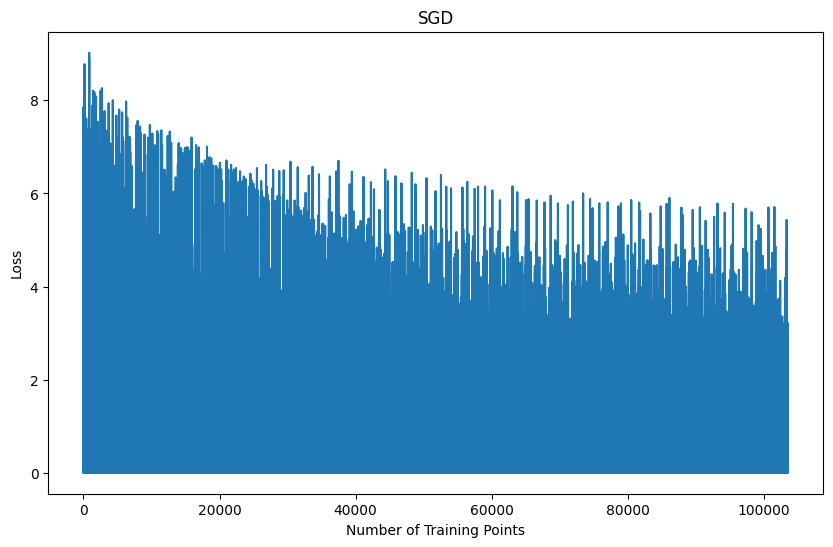

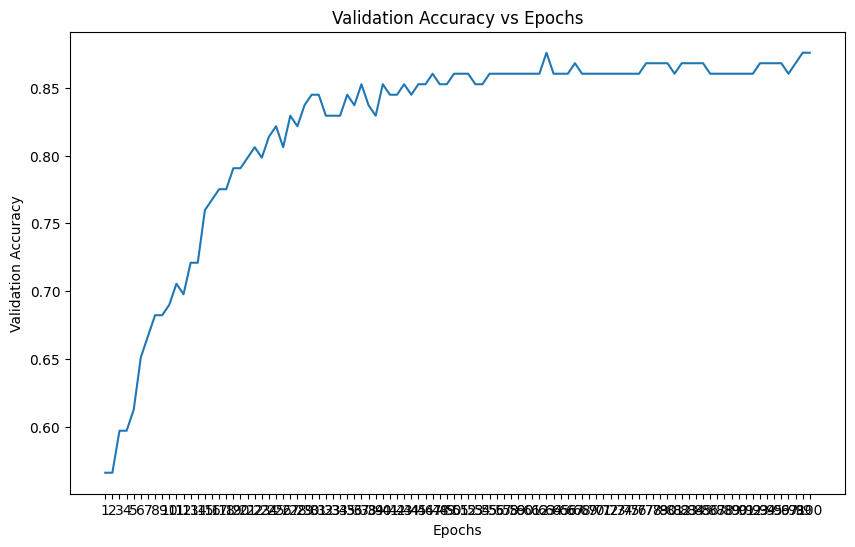

In [84]:
sgd(X_train, y_train, weights, biases, 100, X_val, y_val)

In [105]:
# re-initializing randomly
weights = [np.random.randn(x,y) for x,y in zip(architecture[1:], architecture[:-1])]
biases = [np.random.randn(y,1) for y in architecture[1:]]

Training loss for epoch 0: 1.0840
Training loss for epoch 20: 0.4762
Training loss for epoch 40: 0.3905
Training loss for epoch 60: 0.3495
Training loss for epoch 80: 0.3203


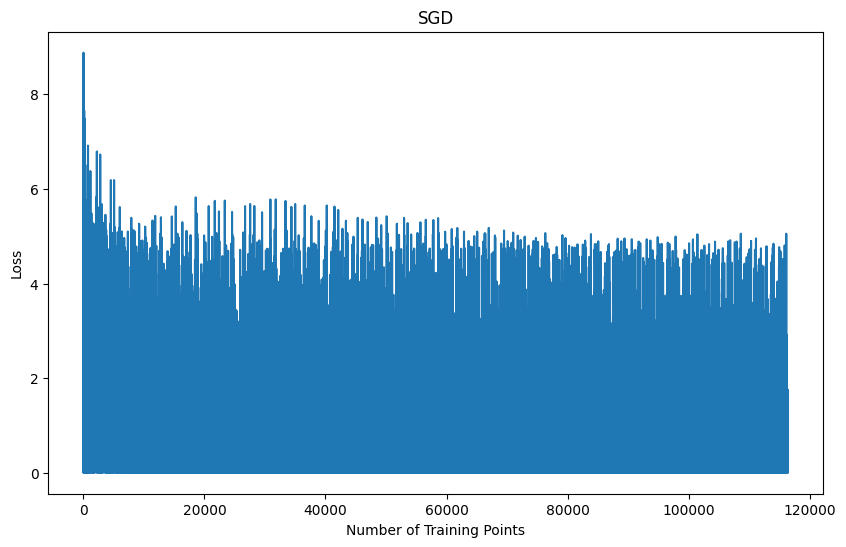

In [106]:
sgd(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), weights, biases, 100)

In [109]:
test_accuracy = evaluate(X_test, y_test, weights, biases)
print(f"Accuracy for test dataset: {test_accuracy:.4f}")

Accuracy for test dataset: 0.8385


In [108]:
def forward(a, weights, biases):
    for i in range(len(weights)):
        z = np.dot(weights[i], a) + biases[i]
        a = sigmoid(z)
    
    return 1 if a >= 0.5 else 0

In [101]:
def predict(test_name, weights, biases):
    # Convert name to feature vector
    name = test_name.lower()

    vec = np.zeros(num_feats)

    # Consider last character of name
    vec[ord(name[-1]) - 97] += 1

    # Consider all bigrams
    for i in range(len(name)-1):
        bigram = name[i:i+2]
        if (ord(bigram[0]) < 97 or ord(bigram[0]) > 122 or ord(bigram[0]) < 97 or ord(bigram[1]) > 122):
            continue
        vec[26 + (ord(bigram[0]) - 97)*26 + (ord(bigram[1]) - 97)] += 1

    vec = vec.reshape(-1, 1)

    z = forward(vec, weights, biases)

    if z == 1:
        print("I am sure " + test_name + " is a boy.")
    elif z == 0:
        print("I am sure " + test_name + " is a girl.")

In [96]:
# Testing with our own example
predict("Preet", weights, biases)
predict("Preeti", weights, biases)
predict("Digvijay", weights, biases)
predict("Rupal", weights, biases)

I am sure Preet is a boy.
I am sure Preeti is a girl.
I am sure Digvijay is a boy.
I am sure Rupal is a girl.
